<a href="https://colab.research.google.com/github/TSffer/semantic-segmentation/blob/master/SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
%tensorflow_version 1.x
%load_ext tensorboard
from keras.backend.tensorflow_backend import  set_session
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if(device_name != '/device:GPU:0'):
     raise SystemError("GPU device not found")
print('Found GPU at: {}'.format(device_name))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

sess = tf.Session(config=config)

set_session(sess)

import keras
from keras.models import *
from keras.layers import *
import keras.backend as K
from keras.callbacks import TensorBoard
from tensorboardcolab import *
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import random
import numpy as np
import datetime
import cv2
import glob
import itertools
import os
import six
import json
from tqdm import tqdm
from keras.models import load_model
import argparse
import matplotlib.pyplot as plt
from types import MethodType
import pytest
import tempfile

!rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Found GPU at: /device:GPU:0
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [0]:
IMAGE_ORDERING_CHANNELS_LAST = "channels_last"
IMAGE_ORDERING_CHANNELS_FIRST = "channels_first"

# Default IMAGE_ORDERING = channels_last
IMAGE_ORDERING = IMAGE_ORDERING_CHANNELS_LAST

In [0]:
if IMAGE_ORDERING == 'channels_first':
    pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.1/" \
                     "vgg16_weights_th_dim_ordering_th_kernels_notop.h5"
elif IMAGE_ORDERING == 'channels_last':
    pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.1/" \
                     "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"


def get_vgg_encoder(input_height=224,  input_width=224, pretrained='imagenet'):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(3, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, 3))

    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    f1 = x
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)
    f5 = x

    if pretrained == 'imagenet':
        VGG_Weights_path = tf.keras.utils.get_file(
            pretrained_url.split("/")[-1], pretrained_url)
        Model(img_input, x).load_weights(VGG_Weights_path)

    return img_input, [f1, f2, f3, f4, f5]

In [0]:
try:
    import imgaug as ia
    from imgaug import augmenters as iaa
except ImportError:
    print("Error in loading augmentation, can't import imgaug. Please make sure it is installed.")


IMAGE_AUGMENTATION_SEQUENCE = None
IMAGE_AUGMENTATION_NUM_TRIES = 10

def _load_augmentation():
    """ Load image augmentation model """

    def sometimes(aug):
        return iaa.Sometimes(0.5, aug)

    global IMAGE_AUGMENTATION_SEQUENCE
    IMAGE_AUGMENTATION_SEQUENCE = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5),  # horizontally flip 50% of all images
            iaa.Flipud(0.2),  # vertically flip 20% of all images
            # crop images by -5% to 10% of their height/width
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode=ia.ALL,
                pad_cval=(0, 255)
            )),
            sometimes(iaa.Affine(
                # scale images to 80-120% of their size, individually per axis
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                # translate by -20 to +20 percent (per axis)
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-45, 45),  # rotate by -45 to +45 degrees
                shear=(-16, 16),  # shear by -16 to +16 degrees
                # use nearest neighbour or bilinear interpolation (fast)
                order=[0, 1],
                # if mode is constant, use a cval between 0 and 255
                cval=(0, 255),
                # use any of scikit-image's warping modes
                # (see 2nd image from the top for examples)
                mode=ia.ALL
            )),
            # execute 0 to 5 of the following (less important) augmenters per
            # image don't execute all of them, as that would often be way too
            # strong
            iaa.SomeOf((0, 5),
                       [
                # convert images into their superpixel representation
                sometimes(iaa.Superpixels(
                    p_replace=(0, 1.0), n_segments=(20, 200))),
                iaa.OneOf([
                    # blur images with a sigma between 0 and 3.0
                    iaa.GaussianBlur((0, 3.0)),
                    # blur image using local means with kernel sizes
                    # between 2 and 7
                    iaa.AverageBlur(k=(2, 7)),
                    # blur image using local medians with kernel sizes
                    # between 2 and 7
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(
                            0.75, 1.5)),  # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(
                    0, 2.0)),  # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                # add gaussian noise to images
                iaa.AdditiveGaussianNoise(loc=0, scale=(
                    0.0, 0.05*255), per_channel=0.5),
                iaa.OneOf([
                    # randomly remove up to 10% of the pixels
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(
                        0.02, 0.05), per_channel=0.2),
                ]),
                # invert color channels
                iaa.Invert(0.05, per_channel=True),
                # change brightness of images (by -10 to 10 of original value)
                iaa.Add((-10, 10), per_channel=0.5),
                # change hue and saturation
                iaa.AddToHueAndSaturation((-20, 20)),
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply(
                                (0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply(
                            (0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization(
                            (0.5, 2.0))
                    )
                ]),
                # improve or worsen the contrast
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
                iaa.Grayscale(alpha=(0.0, 1.0)),
                # move pixels locally around (with random strengths)
                sometimes(iaa.ElasticTransformation(
                    alpha=(0.5, 3.5), sigma=0.25)),
                # sometimes move parts of the image around
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
                random_order=True
            )
        ],
        random_order=True
    )


def _augment_seg(img, seg):

    if not IMAGE_AUGMENTATION_SEQUENCE:
        _load_augmentation()

    # Create a deterministic augmentation from the random one
    aug_det = IMAGE_AUGMENTATION_SEQUENCE.to_deterministic()
    # Augment the input image
    image_aug = aug_det.augment_image(img)

    segmap = ia.SegmentationMapOnImage(
        seg, nb_classes=np.max(seg) + 1, shape=img.shape)
    segmap_aug = aug_det.augment_segmentation_maps(segmap)
    segmap_aug = segmap_aug.get_arr_int()

    return image_aug, segmap_aug


def _try_n_times(fn, n, *args, **kargs):
    """ Try a function N times """
    attempts = 0
    while attempts < n:
        try:
            return fn(*args, **kargs)
        except Exception:
            attempts += 1

    return fn(*args, **kargs)


def augment_seg(img, seg):
    return _try_n_times(_augment_seg, IMAGE_AUGMENTATION_NUM_TRIES, img, seg)

In [0]:
try:
    from tqdm import tqdm
except ImportError:
    print("tqdm not found, disabling progress bars")
    def tqdm(iter):
        return iter

DATA_LOADER_SEED = 0

random.seed(DATA_LOADER_SEED)
class_colors = [(random.randint(0, 255), random.randint(
    0, 255), random.randint(0, 255)) for _ in range(5000)]


class DataLoaderError(Exception):
    pass

def get_pairs_from_paths(images_path, segs_path, ignore_non_matching=False):
    """ Find all the images from the images_path directory and
        the segmentation images from the segs_path directory
        while checking integrity of data """

    ACCEPTABLE_IMAGE_FORMATS = [".jpg", ".jpeg", ".png"]
    ACCEPTABLE_SEGMENTATION_FORMATS = [".png"]

    image_files = []
    segmentation_files = {}

    for dir_entry in os.listdir(images_path):
        if os.path.isfile(os.path.join(images_path, dir_entry)) and \
                os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            image_files.append((file_name, file_extension, os.path.join(images_path, dir_entry)))

    for dir_entry in os.listdir(segs_path):
        if os.path.isfile(os.path.join(segs_path, dir_entry)) and \
                os.path.splitext(dir_entry)[1] in ACCEPTABLE_SEGMENTATION_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            if file_name in segmentation_files:
                raise DataLoaderError("Segmentation file with filename {0} already exists and is ambiguous to resolve with path {1}. Please remove or rename the latter.".format(file_name, os.path.join(segs_path, dir_entry)))
            segmentation_files[file_name] = (file_extension, os.path.join(segs_path, dir_entry))

    return_value = []
    # Match the images and segmentations
    for image_file, _, image_full_path in image_files:
        if image_file in segmentation_files:
            return_value.append((image_full_path, segmentation_files[image_file][1]))
        elif ignore_non_matching:
            continue
        else:
            # Error out
            raise DataLoaderError("No corresponding segmentation found for image {0}.".format(image_full_path))

    return return_value


def get_image_array(image_input, width, height, imgNorm="sub_mean",
                  ordering='channels_first'):
    """ Load image array from input """

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif  isinstance(image_input, six.string_types)  :
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_image_array: path {0} doesn't exist".format(image_input))
        img = cv2.imread(image_input, 1)
    else:
        raise DataLoaderError("get_image_array: Can't process input type {0}".format(str(type(image_input))))

    if imgNorm == "sub_and_divide":
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img[:, :, 0] -= 103.939
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 123.68
        img = img[:, :, ::-1]
    elif imgNorm == "divide":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img/255.0

    if ordering == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    return img


def get_segmentation_array(image_input, nClasses, width, height, no_reshape=False):
    """ Load segmentation array from input """

    seg_labels = np.zeros((height, width, nClasses))

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types) :
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_segmentation_array: path {0} doesn't exist".format(image_input))
        img = cv2.imread(image_input, 1)
    else:
        raise DataLoaderError("get_segmentation_array: Can't process input type {0}".format(str(type(image_input))))

    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    img = img[:, :, 0]

    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c).astype(int)

    if not no_reshape:
        seg_labels = np.reshape(seg_labels, (width*height, nClasses))

    return seg_labels


def verify_segmentation_dataset(images_path, segs_path, n_classes, show_all_errors=False):
    try:
        img_seg_pairs = get_pairs_from_paths(images_path, segs_path)
        if not len(img_seg_pairs):
            print("Couldn't load any data from images_path: {0} and segmentations path: {1}".format(images_path, segs_path))
            return False

        return_value = True
        for im_fn, seg_fn in tqdm(img_seg_pairs):
            img = cv2.imread(im_fn)
            seg = cv2.imread(seg_fn)
            # Check dimensions match
            if not img.shape == seg.shape:
                return_value = False
                print("The size of image {0} and its segmentation {1} doesn't match (possibly the files are corrupt).".format(im_fn, seg_fn))
                if not show_all_errors:
                    break
            else:
                max_pixel_value = np.max(seg[:, :, 0])
                if max_pixel_value >= n_classes:
                    return_value = False
                    print("The pixel values of the segmentation image {0} violating range [0, {1}]. Found maximum pixel value {2}".format(seg_fn, str(n_classes - 1), max_pixel_value))
                    if not show_all_errors:
                        break
        if return_value:
            print("Dataset verified! ")
        else:
            print("Dataset not verified!")
        return return_value
    except DataLoaderError as e:
        print("Found error during data loading\n{0}".format(str(e)))
        return False

def image_segmentation_generator(images_path, segs_path, batch_size,
                                 n_classes, input_height, input_width,
                                 output_height, output_width,
                                 do_augment=False):

    img_seg_pairs = get_pairs_from_paths(images_path, segs_path)
    random.shuffle(img_seg_pairs)
    zipped = itertools.cycle(img_seg_pairs)

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            im, seg = next(zipped)

            im = cv2.imread(im, 1)
            seg = cv2.imread(seg, 1)

            if do_augment:
                im, seg[:, :, 0] = augment_seg(im, seg[:, :, 0])

            X.append(get_image_array(im, input_width,
                                   input_height, ordering=IMAGE_ORDERING))
            Y.append(get_segmentation_array(
                seg, n_classes, output_width, output_height))

        yield np.array(X), np.array(Y)

In [0]:
EPS = 1e-12


def get_iou(gt, pr, n_classes):
    class_wise = np.zeros(n_classes)
    for cl in range(n_classes):
        intersection = np.sum((gt == cl)*(pr == cl))
        union = np.sum(np.maximum((gt == cl), (pr == cl)))
        iou = float(intersection)/(union + EPS)
        class_wise[cl] = iou
    return class_wise

In [0]:
random.seed(DATA_LOADER_SEED)

def model_from_checkpoint_path(checkpoints_path):

    assert (os.path.isfile(checkpoints_path+"_config.json")
            ), "Checkpoint not found."
    model_config = json.loads(
        open(checkpoints_path+"_config.json", "r").read())
    latest_weights = find_latest_checkpoint(checkpoints_path)
    assert (latest_weights is not None), "Checkpoint not found."
    model = model_from_name[model_config['model_class']](
        model_config['n_classes'], input_height=model_config['input_height'],
        input_width=model_config['input_width'])
    print("loaded weights ", latest_weights)
    model.load_weights(latest_weights)
    return model


def predict(model=None, inp=None, out_fname=None, checkpoints_path=None):

    if model is None and (checkpoints_path is not None):
        model = model_from_checkpoint_path(checkpoints_path)
    #model.summary()
    assert (inp is not None)
    assert((type(inp) is np.ndarray) or isinstance(inp, six.string_types)
           ), "Inupt should be the CV image or the input file name"

    if isinstance(inp, six.string_types):
        inp = cv2.imread(inp)

    assert len(inp.shape) == 3, "Image should be h,w,3 "
    orininal_h = inp.shape[0]
    orininal_w = inp.shape[1]

    output_width = model.output_width
    output_height = model.output_height
    input_width = model.input_width
    input_height = model.input_height
    n_classes = model.n_classes

    x = get_image_array(inp, input_width, input_height, ordering=IMAGE_ORDERING)
    pr = model.predict(np.array([x]))[0]
    pr = pr.reshape((output_height,  output_width, n_classes)).argmax(axis=2)

    seg_img = np.zeros((output_height, output_width, 3))
    colors = class_colors

    for c in range(n_classes):
        seg_img[:, :, 0] += ((pr[:, :] == c)*(colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((pr[:, :] == c)*(colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((pr[:, :] == c)*(colors[c][2])).astype('uint8')

    seg_img = cv2.resize(seg_img, (orininal_w, orininal_h))

    if out_fname is not None:
        cv2.imwrite(out_fname, seg_img)

    return pr


def predict_multiple(model=None, inps=None, inp_dir=None, out_dir=None,
                     checkpoints_path=None):

    if model is None and (checkpoints_path is not None):
        model = model_from_checkpoint_path(checkpoints_path)

    if inps is None and (inp_dir is not None):
        inps = glob.glob(os.path.join(inp_dir, "*.jpg")) + glob.glob(
            os.path.join(inp_dir, "*.png")) + \
            glob.glob(os.path.join(inp_dir, "*.jpeg"))

    assert type(inps) is list

    all_prs = []

    for i, inp in enumerate(tqdm(inps)):
        if out_dir is None:
            out_fname = None
        else:
            if isinstance(inp, six.string_types):
                out_fname = os.path.join(out_dir, os.path.basename(inp))
            else:
                out_fname = os.path.join(out_dir, str(i) + ".jpg")

        pr = predict(model, inp, out_fname)
        all_prs.append(pr)

    return all_prs



def evaluate( model=None , inp_images=None , annotations=None,inp_images_dir=None ,annotations_dir=None , checkpoints_path=None ):
    
    if model is None:
        assert (checkpoints_path is not None) , "Please provide the model or the checkpoints_path"
        model = model_from_checkpoint_path(checkpoints_path)
        
    if inp_images is None:
        assert (inp_images_dir is not None) , "Please privide inp_images or inp_images_dir"
        assert (annotations_dir is not None) , "Please privide inp_images or inp_images_dir"
        
        paths = get_pairs_from_paths(inp_images_dir , annotations_dir )
        paths = list(zip(*paths))
        inp_images = list(paths[0])
        annotations = list(paths[1])
        
    assert type(inp_images) is list
    assert type(annotations) is list
        
    tp = np.zeros( model.n_classes  )
    fp = np.zeros( model.n_classes  )
    fn = np.zeros( model.n_classes  )
    n_pixels = np.zeros( model.n_classes  )
    
    for inp , ann   in tqdm( zip( inp_images , annotations )):
        pr = predict(model , inp )
        gt = get_segmentation_array( ann , model.n_classes ,  model.output_width , model.output_height , no_reshape=True  )
        gt = gt.argmax(-1)
        pr = pr.flatten()
        gt = gt.flatten()
                
        for cl_i in range(model.n_classes ):
            
            tp[ cl_i ] += np.sum( (pr == cl_i) * (gt == cl_i) )
            fp[ cl_i ] += np.sum( (pr == cl_i) * ((gt != cl_i)) )
            fn[ cl_i ] += np.sum( (pr != cl_i) * ((gt == cl_i)) )
            n_pixels[ cl_i ] += np.sum( gt == cl_i  )
            
    cl_wise_score = tp / ( tp + fp + fn + 0.000000000001 )
    n_pixels_norm = n_pixels /  np.sum(n_pixels)
    frequency_weighted_IU = np.sum(cl_wise_score*n_pixels_norm)
    mean_IU = np.mean(cl_wise_score)
    return {"frequency_weighted_IU":frequency_weighted_IU , "mean_IU":mean_IU , "class_wise_IU":cl_wise_score }


In [0]:
def find_latest_checkpoint(checkpoints_path, fail_safe=True):

    def get_epoch_number_from_path(path):
        return path.replace(checkpoints_path, "").strip(".")

    # Get all matching files
    all_checkpoint_files = glob.glob(checkpoints_path + ".*")
    # Filter out entries where the epoc_number part is pure number
    all_checkpoint_files = list(filter(lambda f: get_epoch_number_from_path(f).isdigit(), all_checkpoint_files))
    if not len(all_checkpoint_files):
        # The glob list is empty, don't have a checkpoints_path
        if not fail_safe:
            raise ValueError("Checkpoint path {0} invalid".format(checkpoints_path))
        else:
            return None

    # Find the checkpoint file with the maximum epoch
    latest_epoch_checkpoint = max(all_checkpoint_files, key=lambda f: int(get_epoch_number_from_path(f)))
    return latest_epoch_checkpoint


def train(model,
          train_images,
          train_annotations,
          input_height=None,
          input_width=None,
          n_classes=None,
          verify_dataset=True,
          checkpoints_path=None,
          epochs=5,
          batch_size=2,
          validate=False,
          val_images=None,
          val_annotations=None,
          val_batch_size=2,
          validation_steps=2,
          auto_resume_checkpoint=False,
          load_weights=None,
          steps_per_epoch=512,
          optimizer_name='adam'
          ):
    
    result=None
    tb = TensorBoard(log_dir='logs',write_graph=True)
    mc = ModelCheckpoint(mode='max',filepath='/content/drive/My Drive/checkpointsSegNet/segnet_vgg.1', monitor='acc',save_best_only='True',save_weights_only='True',verbose=1)
    es = EarlyStopping(mode='min',monitor='val_loss',patience=50,verbose=1)
    callbacks = [tb,mc,es]
    
    # check if user gives model name instead of the model object
    if isinstance(model, six.string_types):
        # create the model from the name
        assert (n_classes is not None), "Please provide the n_classes"
        if (input_height is not None) and (input_width is not None):
            model = model_from_name[model](
                n_classes, input_height=input_height, input_width=input_width)
        else:
            model = model_from_name[model](n_classes)

    n_classes = model.n_classes
    input_height = model.input_height
    input_width = model.input_width
    output_height = model.output_height
    output_width = model.output_width

    if validate:
        assert val_images is not None
        assert val_annotations is not None

    if optimizer_name is not None:
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer_name,
                      metrics=['accuracy'])

    if checkpoints_path is not None:
        with open(checkpoints_path+"_config.json", "w") as f:
            json.dump({
                "model_class": model.model_name,
                "n_classes": n_classes,
                "input_height": input_height,
                "input_width": input_width,
                "output_height": output_height,
                "output_width": output_width
            }, f)

    if load_weights is not None and len(load_weights) > 0:
        print("Loading weights from ", load_weights)
        model.load_weights(load_weights)

    if auto_resume_checkpoint and (checkpoints_path is not None):
        latest_checkpoint = find_latest_checkpoint(checkpoints_path)
        if latest_checkpoint is not None:
            print("Loading the weights from latest checkpoint ",
                  latest_checkpoint)
            model.load_weights(latest_checkpoint)

    if verify_dataset:
        print("Verifying training dataset")
        verified = verify_segmentation_dataset(train_images, train_annotations, n_classes)
        assert verified
        if validate:
            print("Verifying validation dataset")
            verified = verify_segmentation_dataset(val_images, val_annotations, n_classes)
            assert verified

    train_gen = image_segmentation_generator(
        train_images, train_annotations,  batch_size,  n_classes,
        input_height, input_width, output_height, output_width)

    if validate:
        val_gen = image_segmentation_generator(
            val_images, val_annotations,  val_batch_size,
            n_classes, input_height, input_width, output_height, output_width)

    if not validate:
        #for ep in range(epochs):
            #print("Starting Epoch ", ep)
        result=model.fit_generator(train_gen, steps_per_epoch, epochs=epochs,callbacks=callbacks,use_multiprocessing=True,verbose=1)
            #if checkpoints_path is not None:
        model.save_weights(checkpoints_path + "." + '1',overwrite=True)
                #print("saved ", checkpoints_path + ".model." + str(ep))
            #print("Finished Epoch", ep)
    else:
        #for ep in range(epochs):
            #print("Starting Epoch ", ep)
        result=model.fit_generator(train_gen, steps_per_epoch,
                                   validation_data=val_gen,
                                   validation_steps=validation_steps,  epochs=epochs,callbacks=callbacks,use_multiprocessing=True,verbose=1)
            #if checkpoints_path is not None:
        model.save_weights(checkpoints_path + "." + '1',overwrite=True)
                #print("saved ", checkpoints_path + ".model." + str(ep))
            #print("Finished Epoch", ep)
    return result

In [0]:
# source m1 , dest m2
def transfer_weights(m1, m2, verbose=True):

    assert len(m1.layers) == len(
        m2.layers), "Both models should have same number of layers"

    nSet = 0
    nNotSet = 0

    if verbose:
        print("Copying weights ")
        bar = tqdm(zip(m1.layers, m2.layers))
    else:
        bar = zip(m1.layers, m2.layers)

    for l, ll in bar:

        if not any([w.shape != ww.shape for w, ww in zip(list(l.weights),
                                                         list(ll.weights))]):
            if len(list(l.weights)) > 0:
                ll.set_weights(l.get_weights())
                nSet += 1
        else:
            nNotSet += 1

    if verbose:
        print("Copied weights of %d layers and skipped %d layers" %
              (nSet, nNotSet))


def resize_image(inp,  s, data_format):

    try:

        return Lambda(lambda x: K.resize_images(x,
                                                height_factor=s[0],
                                                width_factor=s[1],
                                                data_format=data_format,
                                                interpolation='bilinear'))(inp)

    except Exception as e:
        # if keras is old, then rely on the tf function
        # Sorry theano/cntk users!!!
        assert data_format == 'channels_last'
        assert IMAGE_ORDERING == 'channels_last'

        import tensorflow as tf

        return Lambda(
            lambda x: tf.image.resize_images(
                x, (K.int_shape(x)[1]*s[0], K.int_shape(x)[2]*s[1]))
        )(inp)


def get_segmentation_model(input, output):

    img_input = input
    o = output

    o_shape = Model(img_input, o).output_shape
    i_shape = Model(img_input, o).input_shape

    if IMAGE_ORDERING == 'channels_first':
        output_height = o_shape[2]
        output_width = o_shape[3]
        input_height = i_shape[2]
        input_width = i_shape[3]
        n_classes = o_shape[1]
        o = (Reshape((-1, output_height*output_width)))(o)
        o = (Permute((2, 1)))(o)
    elif IMAGE_ORDERING == 'channels_last':
        output_height = o_shape[1]
        output_width = o_shape[2]
        input_height = i_shape[1]
        input_width = i_shape[2]
        n_classes = o_shape[3]
        o = (Reshape((output_height*output_width, -1)))(o)

    o = (Activation('softmax'))(o)
    model = Model(img_input, o)
    model.output_width = output_width
    model.output_height = output_height
    model.n_classes = n_classes
    model.input_height = input_height
    model.input_width = input_width
    model.model_name = ""

    model.train = MethodType(train, model)
    model.predict_segmentation = MethodType(predict, model)
    model.predict_multiple = MethodType(predict_multiple, model)
    model.evaluate_segmentation = MethodType(evaluate, model)

    return model

In [0]:
def segnet_decoder(f, n_classes, n_up=3):

    assert n_up >= 2

    o = f
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(512, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(256, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    for _ in range(n_up-2):
        o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
        o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
        o = (Conv2D(128, (3, 3), padding='valid',
             data_format=IMAGE_ORDERING))(o)
        o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(64, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = Conv2D(n_classes, (3, 3), padding='same',
               data_format=IMAGE_ORDERING)(o)

    return o


def _segnet(n_classes, encoder,  input_height=416, input_width=608,
            encoder_level=3):

    img_input, levels = encoder(
        input_height=input_height,  input_width=input_width)

    feat = levels[encoder_level]
    o = segnet_decoder(feat, n_classes, n_up=3)
    model = get_segmentation_model(img_input, o)

    return model



def vgg_segnet(n_classes, input_height=416, input_width=608, encoder_level=3):

    model = _segnet(n_classes, get_vgg_encoder,  input_height=input_height,
                    input_width=input_width, encoder_level=encoder_level)
    model.model_name = "vgg_segnet"
    return model

if __name__ == '__main__':
    m = vgg_segnet(101)


In [0]:
model_from_name = {}
model_from_name["vgg_segnet"] = vgg_segnet

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  3%|▎         | 10/367 [00:00<00:03, 97.21it/s]

103.0
26.0
Verifying training dataset


 11%|█         | 11/101 [00:00<00:00, 102.09it/s]

Dataset verified! 
Verifying validation dataset


100%|██████████| 101/101 [00:00<00:00, 104.64it/s]


Dataset verified! 
Epoch 1/300
103/103 [==============================] - 83s 805ms/step - loss: 0.8279 - acc: 0.7569 - val_loss: 0.7086 - val_acc: 0.8108

Epoch 00001: acc improved from -inf to 0.75692, saving model to /content/drive/My Drive/checkpointsSegNet/segnet_vgg.1
Epoch 2/300
103/103 [==============================] - 70s 680ms/step - loss: 0.5682 - acc: 0.8290 - val_loss: 1.0341 - val_acc: 0.6556

Epoch 00002: acc improved from 0.75692 to 0.82905, saving model to /content/drive/My Drive/checkpointsSegNet/segnet_vgg.1
Epoch 3/300
103/103 [==============================] - 73s 707ms/step - loss: 0.4792 - acc: 0.8521 - val_loss: 1.5102 - val_acc: 0.4590

Epoch 00003: acc improved from 0.82905 to 0.85210, saving model to /content/drive/My Drive/checkpointsSegNet/segnet_vgg.1
Epoch 4/300
103/103 [==============================] - 72s 703ms/step - loss: 0.4130 - acc: 0.8700 - val_loss: 1.1741 - val_acc: 0.6312

Epoch 00004: acc improved from 0.85210 to 0.87005, saving model to /co

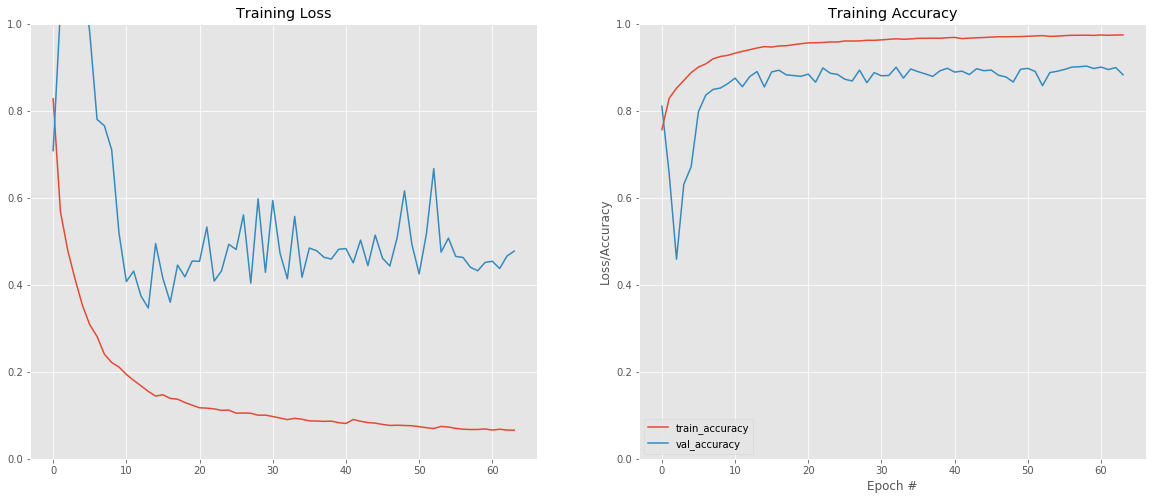

101it [00:05, 17.76it/s]


{'frequency_weighted_IU': 0.806771913564837, 'mean_IU': 0.5320400560103097, 'class_wise_IU': array([0.88248873, 0.80671625, 0.08613409, 0.94878635, 0.84416661,
       0.8146363 , 0.30075879, 0.307686  , 0.58096034, 0.28494853,
       0.29291503, 0.23428365])}


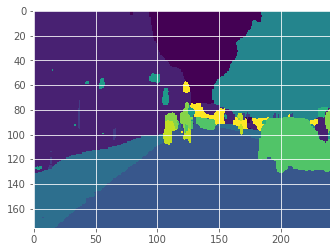

In [74]:
tr_im = "/content/drive/My Drive/CamVid/train"
tr_an = "/content/drive/My Drive/CamVid/trainannot"
val_im = "/content/drive/My Drive/CamVid/val"
val_an = "/content/drive/My Drive/CamVid/valannot"
check_p = "/content/drive/My Drive/checkpointsSegNet/segnet_vgg"

load_w = "/content/drive/My Drive/checkpointsSegNet/segnet_vgg.1"

model = vgg_segnet(n_classes=12, input_height=352, input_width=480)

batch_size = 16
num_data = 4096
steps_per_epoch = np.ceil(float(num_data - round(0.2*num_data))/float(batch_size))
print(steps_per_epoch)

validation_steps = np.ceil(float((round(0.2*num_data)))/float(batch_size))
print(validation_steps)

num_epochs = 300

result = model.train(train_images=tr_im,
            train_annotations=tr_an,
            checkpoints_path=check_p,
            epochs=num_epochs,
            batch_size=batch_size,
            validate=True,
            val_images=val_im,
            val_annotations=val_an,
            val_batch_size=batch_size,
            #auto_resume_checkpoint=True,
            #load_weights=load_w,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            optimizer_name='adam'
            )

N = len(result.history['loss'])
print(N)

plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

fig.add_subplot(1, 2, 2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["acc"], label="train_accuracy")
plt.plot(np.arange(0, N), result.history["val_acc"],label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

out = model.predict_segmentation(
    inp="/content/drive/My Drive/dataset1/images_prepped_test/0016E5_07965.png",
    out_fname="/content/drive/My Drive/tmpSegNet/out.png"
)


plt.imshow(out)

print(model.evaluate_segmentation(inp_images_dir="/content/drive/My Drive/dataset1/images_prepped_test",annotations_dir="/content/drive/My Drive/dataset1/annotations_prepped_test"))

In [75]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4701), started 2:07:03 ago. (Use '!kill 4701' to kill it.)

In [76]:
checkpoints_path="/content/drive/My Drive/checkpointsSegNet/segnet_vgg"
input_path="/content/drive/My Drive/CamVid/test/0001TP_008670.png"
output_path="/content/drive/My Drive/tmpSegNet/out2.png"

model_config = {"model_class": "vgg_segnet", "n_classes": 12, "input_height": 416, "input_width": 608, "output_height": 208, "output_width": 304}
predict(inp=input_path, out_fname=output_path,checkpoints_path=checkpoints_path)
predict_multiple(inp_dir="/content/drive/My Drive/CamVid/test", out_dir="/content/drive/My Drive/tmpSegNet",checkpoints_path=checkpoints_path)

loaded weights  /content/drive/My Drive/checkpointsSegNet/segnet_vgg.1
loaded weights  /content/drive/My Drive/checkpointsSegNet/segnet_vgg.1


100%|██████████| 233/233 [00:14<00:00, 16.31it/s]


[array([[ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        ...,
        [ 3,  3,  3, ..., 11, 11, 11],
        [ 3,  3,  3, ..., 11, 11, 11],
        [ 3,  3,  3, ..., 11, 11, 11]]), array([[ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        ...,
        [ 4,  4,  4, ..., 11, 11, 11],
        [ 4,  4,  4, ..., 11, 11, 11],
        [ 4,  4,  4, ..., 11, 11, 11]]), array([[ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1],
        ...,
        [ 3,  3,  3, ..., 11, 11, 11],
        [ 3,  3,  3, ..., 11, 11, 11],
        [ 3,  3,  3, ..., 11, 11, 11]]), array([[ 5,  5,  5, ...,  1,  1,  1],
        [ 5,  5,  5, ...,  1,  1,  1],
        [ 5,  5,  5, ...,  1,  1,  1],
        ...,
        [ 4,  4,  4, ..., 11, 11, 11],
        [ 4,  3,  3, ..., 11, 11, 11],
        [ 3,  3,  3, ..., 11, 11, 11]]), array([

In [77]:
evaluate(inp_images_dir="/content/drive/My Drive/dataset1/images_prepped_test", annotations_dir="/content/drive/My Drive/dataset1/annotations_prepped_test", checkpoints_path=checkpoints_path)

loaded weights  /content/drive/My Drive/checkpointsSegNet/segnet_vgg.1


101it [00:08, 18.73it/s]


{'class_wise_IU': array([0.88248873, 0.80671625, 0.08613409, 0.94878635, 0.84416661,
        0.8146363 , 0.30075879, 0.307686  , 0.58096034, 0.28494853,
        0.29291503, 0.23428365]),
 'frequency_weighted_IU': 0.806771913564837,
 'mean_IU': 0.5320400560103097}